# Data Analysis for SIGCHI

In [1]:
# importing required components 
import os,sys
import glob, time, json
import urllib
import random
import torch
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import librosa
import librosa.display
import matplotlib.pyplot as plt 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
from imutils import paths
from tqdm import tqdm_notebook as tqdm
from keras.models import Model
from keras.utils import np_utils
from PIL import Image
from pdf2image import convert_from_path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
# from efficientnet_pytorch import EfficientNet

- - -

* Converting m4a file into wav file

In [ ]:
from pydub import AudioSegment

In [ ]:
m4a_file = './data/breathe/1.m4a'
wav_filename = r"./data/breathe/1.wav"

In [ ]:
track = AudioSegment.from_file(m4a_file,  format= 'm4a')
file_handle = track.export(wav_filename, format='wav')

In [ ]:
# Convert all file extensions to m4a (if required)
folder = 'E:/RESEARCH/Datasets/breathe/exhale'

for filename in os.listdir(folder):
    infilename = os.path.join(folder,filename)
    if not os.path.isfile(infilename): continue
    oldbase = os.path.splitext(filename)
    newname = infilename.replace('.tmp', '.m4a')
    output = os.rename(infilename, newname)

In [ ]:
# Convert m4a extension files to wav extension files
formats_to_convert = ['.m4a']

for (dirpath, dirnames, filenames) in os.walk("E:/RESEARCH/Datasets/breathe/exhale/"):
    for filename in filenames:
        if filename.endswith(tuple(formats_to_convert)):
            filepath = dirpath + '/' + filename
            (path, file_extension) = os.path.splitext(filepath)
            file_extension_final = file_extension.replace('.', '')
            try:
                track = AudioSegment.from_file(filepath,
                        file_extension_final)
                wav_filename = filename.replace(file_extension_final, 'wav')
                wav_path = dirpath + '/' + wav_filename
                print('CONVERTING: ' + str(filepath))
                file_handle = track.export(wav_path, format='wav')
                os.remove(filepath)
            except:
                print("ERROR CONVERTING " + str(filepath))

# From Here

- - -

## MFCC transforming from wav files

In [ ]:
# y, sr = librosa.load("E:/RESEARCH/BRAIN/VFT/005/VerbalFluencyTest-005-1BaseLine-3.wav")
# mfcc1 = librosa.feature.mfcc(y=y, sr=sr)

In [ ]:
# mfcc1.shape

In [ ]:
# path = "E:/RESEARCH/Datasets/BreathingData/normal/20_2.wav"
# path = "E:/RESEARCH/Datasets/BreathingData/weak/20_1.wav"
path = "E:/RESEARCH/Datasets/BreathingData/strong/20_3.wav"
sample_rate = 15000

In [ ]:
x = librosa.load(path,sample_rate)[0]
S = librosa.feature.melspectrogram(x, sr=sample_rate, n_mels=1500)
log_S = librosa.power_to_db(S, ref=np.max)
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=3)

In [ ]:
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

### MFCC

In [ ]:
# plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.tight_layout()
# plt.savefig('E:/RESEARCH/Datasets/breathe/MFCC/strong/20.png')

In [ ]:
# plt.ylabel('MFCC coeffs')
# plt.xlabel('Time')
# plt.title('MFCC')
# plt.colorbar()

### Mel-spectrogram

In [ ]:
min_level_db= -100
def normalize_mel(S):
    return np.clip((S-min_level_db)/-min_level_db,0,1)


def feature_extraction(path):
    y = librosa.load(path,16000)[0]
    S =  librosa.feature.melspectrogram(y=y, n_mels=80, n_fft=512, win_length=400, hop_length=160) # 320/80
    norm_log_S = normalize_mel(librosa.power_to_db(S, ref=np.max))
    return norm_log_S
                        

# a = feature_extraction("E:/RESEARCH/Datasets/BreathingData/normal/20_2.wav")
# a = feature_extraction("E:/RESEARCH/Datasets/BreathingData/weak/20_1.wav")
a = feature_extraction("E:/RESEARCH/Datasets/BreathingData/strong/20_3.wav")

# librosa.display.specshow(a, y_axis='mel', x_axis='time')
librosa.display.specshow(a)

# plt.colorbar(format='%+2.0f dB')
# plt.title('Mel-Spectrogram')
plt.tight_layout()
plt.savefig('E:/RESEARCH/Datasets/breathe/MEL/strong/20.png')
plt.show()

- - -

### Changing file names

In [ ]:
## Checking file path and names
file_path = "E:/RESEARCH/Datasets/breathe/MEL_train/weak/"
file_names = os.listdir(file_path)

In [ ]:
## Changing file names to 1, 2, ...
i = 1
for name in file_names:
    src = os.path.join(file_path, name)
    dst = str(i) + '.png'
    dst = os.path.join(file_path, dst)
    os.rename(src, dst)
    i += 1

- - -

- - -

## Classification with MFCC dataset

In [28]:
class Args:
    # arugments
    epochs=45
    bs=32
    lr=0.001
    momentum=0.8
    num_channels=3
    num_classes=3
    verbose='store_true'
    seed=421

args = Args()    

np.random.seed(args.seed)
random.seed(args.seed)
torch.manual_seed(args.seed)

In [4]:
#Setting torch environment

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device: ', DEVICE)

Using PyTorch version: 1.7.1  Device:  cuda


- - -

In [5]:
class CNN_breathe_one(nn.Module):
    def __init__(self):
        super(CNN_breathe_one, self).__init__() #227*227*3 
        self.conv1 = nn.Conv2d(3, 10, kernel_size=11, stride=4, padding=0) #54*54*10
        self.conv2 = nn.Conv2d(10, 15, kernel_size=5, stride=2, padding=0)
        self.conv3 = nn.Conv2d(15, 20, kernel_size=5, stride=3, padding=0)
        
        self.fc1 = nn.Linear(8 * 8 * 20, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
#         print(x.shape)
        
        x = x.view(-1, 8 * 8 * 20)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
class CNN_breathe_two(nn.Module):
    def __init__(self):
        super(CNN_breathe_two, self).__init__() #256*256*3 
        self.conv1 = nn.Conv2d(3, 10, kernel_size=7, stride=3, padding=0)  # 84*84*10
        self.pool1 = nn.MaxPool2d(kernel_size=2) # 83*83*10
        self.conv2 = nn.Conv2d(10, 15, kernel_size=5, stride=3, padding=0) # 27*27*15
        self.pool2 = nn.MaxPool2d(kernel_size=2) # 26*26*15
        self.conv3 = nn.Conv2d(15, 20, kernel_size=5, stride=3, padding=0) # 8*8*20
        
        self.fc1 = nn.Linear(8 * 8 * 20, 256)
        self.fc2 = nn.Linear(256, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        print(x.shape)
        
        x = x.view(-1, 8 * 8 * 20)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
class CNN_breathe_three(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN_breathe_three, self).__init__()

        def conv_batch(input_size, output_size, stride):
            return nn.Sequential(
                nn.Conv2d(input_size, output_size, 3, stride, 1, bias=False),
                nn.BatchNorm2d(output_size),
                nn.ReLU(inplace=True)
                )

        def conv_depth(input_size, output_size, stride):
            return nn.Sequential(
                nn.Conv2d(input_size, input_size, 3, stride, 1, groups=input_size, bias=False),
                nn.BatchNorm2d(input_size),
                nn.ReLU(inplace=True),
                
                nn.Conv2d(input_size, output_size, 1, 1, 0, bias=False),
                nn.BatchNorm2d(output_size),
                nn.ReLU(inplace=True),
                )

        self.model = nn.Sequential(
            conv_batch(3, 32, 2),
            conv_depth(32, 64, 1),
            conv_depth(64, 128, 2),
#             conv_depth(128, 256, 2),

            nn.AdaptiveAvgPool2d(1)
        )
#         self.fc1 = nn.Linear(1024, 100)
#         self.fc2 = nn.Linear(1024, num_classes)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.model(x)
#         x = x.view(-1, 1024)
        x = x.view(-1, 128)
#         x = self.fc1(x)
        x = self.fc2(x)
        return x


* Pretrained model

In [8]:
model_resnet18 = models.resnet18(pretrained=True)
model_mobnetv2 = models.mobilenet_v2(pretrained=True)
model_alexnet = models.alexnet(pretrained=True)

In [9]:
## resnet 구조는 마지막 fc layer의 out_features 를 바꿔주면 되고.
model_resnet18.fc = nn.Linear(in_features = 512, out_features = args.num_classes)
model_mobnetv2.classifier = nn.Linear(in_features = 1280, out_features = args.num_classes)

- - -

### Select the model

In [10]:
# model = CNN_breathe_one().to(DEVICE)
model = CNN_breathe_three(in_channels=3, num_classes=3).to(DEVICE)
# model = model_resnet18.to(DEVICE)
# model = model_mobnetv2.to(DEVICE)
# model = model_alexnet.to(DEVICE)

In [11]:
# Data Transformation
data_transforms = transforms.Compose([
#     transforms.Resize((227,227)),
#     transforms.Resize((256,256)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.ColorJitter(contrast=(0.3, 1), saturation=(0.3, 1)),
    transforms.ToTensor()
])

In [12]:
# Uploading image data
mfcc_data = datasets.ImageFolder(root = 'E:/RESEARCH/Datasets/breathe/MFCC_train/', transform = data_transforms)

In [13]:
train_size = int(0.8 * len(mfcc_data))
test_size = len(mfcc_data)-train_size
print(train_size)
print(test_size)

240
60


In [14]:
train_dataset, test_dataset = torch.utils.data.random_split(mfcc_data, [train_size, test_size])

In [15]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.bs, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.bs, shuffle=False, num_workers=4)

In [16]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(labels)

tensor([0, 0, 1, 0, 0, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2,
        0, 2, 0, 1, 0, 0, 1, 2])


- - -

### Optimizer and Objective Function

In [17]:
# Setting Optimizer and Objective Function

criterion = nn.CrossEntropyLoss() ## setup the loss function
optimizer = torch.optim.Adam(model.parameters(), lr = args.lr)
# scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch: 0.95 ** args.epochs)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, total_steps=50,anneal_strategy='cos')

# print(model)

- - -

### Training

In [18]:
# Function for checking model performance during CNN model

def train(model, train_loader, optimizer, log_interval):
    model.train()
    print(optimizer.param_groups[0]['lr'])
    
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

#     scheduler.step() #for learning rate scheduler

In [19]:
# Function for checking model performance during the learning process

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    validation =[]

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
    
    test_loss /= (len(test_loader)) 
    validation_accuracy = 100. * correct / len(test_loader.dataset)
    validation.append(validation_accuracy)
    
    return test_loss, validation_accuracy

In [20]:
# Checking train, val loss and accuracy

los_total = []
acc_total = []

for epoch in range(1, args.epochs):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, validation_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tValidation Accuracy: {:.2f} % \n".format(
        epoch, test_loss, validation_accuracy))
    
    los_total.append(test_loss)
    acc_total.append(validation_accuracy)

0.001
Train Epoch: 1 [0/240 (0%)]	Train Loss: 1.071953

[EPOCH: 1], 	Test Loss: 1.0951, 	Validation Accuracy: 35.00 % 

0.001
Train Epoch: 2 [0/240 (0%)]	Train Loss: 0.849908

[EPOCH: 2], 	Test Loss: 1.1087, 	Validation Accuracy: 35.00 % 

0.001
Train Epoch: 3 [0/240 (0%)]	Train Loss: 0.832446

[EPOCH: 3], 	Test Loss: 1.2060, 	Validation Accuracy: 35.00 % 

0.001
Train Epoch: 4 [0/240 (0%)]	Train Loss: 0.786087

[EPOCH: 4], 	Test Loss: 1.2380, 	Validation Accuracy: 35.00 % 

0.001
Train Epoch: 5 [0/240 (0%)]	Train Loss: 0.856533

[EPOCH: 5], 	Test Loss: 1.1894, 	Validation Accuracy: 35.00 % 

0.001
Train Epoch: 6 [0/240 (0%)]	Train Loss: 0.553273

[EPOCH: 6], 	Test Loss: 0.9309, 	Validation Accuracy: 51.67 % 

0.001
Train Epoch: 7 [0/240 (0%)]	Train Loss: 0.592032

[EPOCH: 7], 	Test Loss: 0.8506, 	Validation Accuracy: 46.67 % 

0.001
Train Epoch: 8 [0/240 (0%)]	Train Loss: 0.510489

[EPOCH: 8], 	Test Loss: 1.0443, 	Validation Accuracy: 35.00 % 

0.001
Train Epoch: 9 [0/240 (0%)]	Train 

- - -

## Graphs

In [45]:
acc_total=[0.0, 36.6666666664, 66.66666666664, 69.666666666664, 70.3333333336, 
           72.33330, 75.666666666666664, 75.66666666664, 80.666666666664, 75.6666666666, 
           82.333336, 77.875555555555555, 79.11111111125, 85.222222222225, 85.5555555555, 
           81.222225, 81.222222222222225, 85.33333333333333, 78.66666666666667, 86.66666666666667, 
           91.0, 90.0, 92.0, 92.66666666666667, 93.66666666666667, 
           96.66666666666667, 91.66666666666667, 86.66666666666667, 93.33333333333333, 83.33333333333333, 
           86.66666666,  98.33333333333333, 91.66666666666667, 91.66666666666667, 93.3333333, 
           93.3333333, 98.3333333333, 86.66666666, 91.66666, 91.66666667, 
           94.2333333333, 79.33333333333, 85.0, 93.890, 94.87555, 
           93.87555,  88.33333333333333, 94.87555, 94.87555]

In [46]:
los_total=[1.4086813306808472,  0.8972383618354797,  0.6001080409407615662,  0.550006214727,  0.504353542023897171,  
           0.4494644165039062,  0.437340757429599762,  0.403684657782257, 0.38359791994094849, 0.36094673871994019, 
           0.270862650871277, 0.324568361043930054, 0.25576242804527283, 0.31341782450675964, 0.30834144389629364, 
           0.2839742302894592, 0.258134104013443, 0.24668397754430771, 0.27696130573749542, 0.2951151305437088, 
           0.2647329345345497,  0.3095483058691025, 0.2859398126602173, 0.25098511427640915, 0.25589674711227417, 
           0.23911730647087097, 0.2667325362563133, 0.30100666880607605,  0.22870951890945435, 0.26637283861637115, 
           0.2704706847667694, 0.17034862190485, 0.18016546219587326, 0.2513361468911171, 0.16052847728133202,
           0.16575497388839722, 0.108305437117815018, 0.107487296685576439, 0.10984716564416885, 0.12100118398666382, 
           0.17442912608385086, 0.4014428317546844,  0.36075475066900253, 0.19068868458271027, 0.08382609486579895, 
           0.09742861241102219, 0.24863661229610443, 0.15573369711637497, 0.08436404168605804]

In [49]:
len(los_total)

49

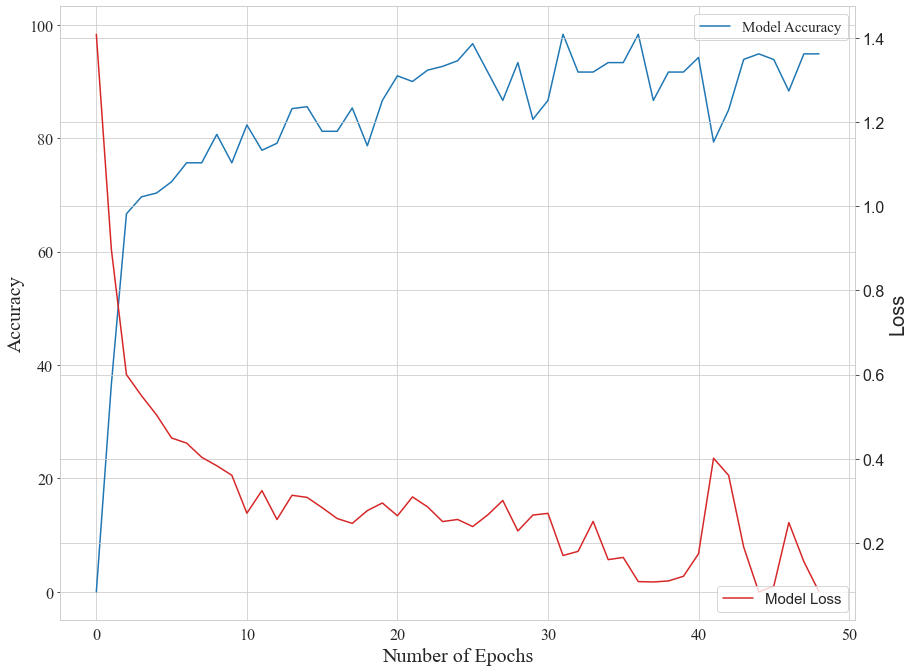

In [50]:
## Accuracy Graphs
plt.rc('font', family='Times New Roman', serif='Times')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=20)

fig, ax = plt.subplots()
fig.subplots_adjust(left=.15, bottom=-1.16, right=1.99, top=.97)

color ='tab:blue'
ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of Epochs')
plt.plot(range(50 -1), acc_total)
ax.legend(['Model Accuracy'],fontsize=15, loc='upper right')
sns.set_style('whitegrid')

ax1 = ax.twinx()
color = 'tab:red'
ax1.set_ylabel('Loss')
ax1.plot(range(50 -1), los_total, color = color)
ax1.legend(['Model Loss'], fontsize=15, loc='lower right')
sns.set_style('whitegrid')
# plt.savefig('./classification.png')

## Model Performance

[[21.  0.  0.]
 [ 4. 17.  0.]
 [ 0.  0. 18.]]


Text(0.5, -7.571874999999999, 'Predicted label')

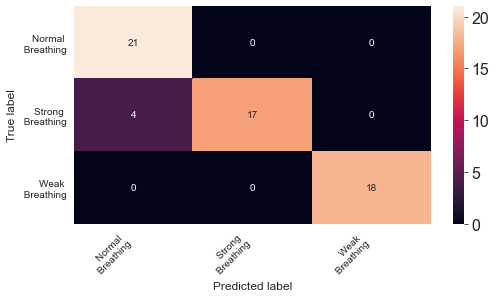

In [35]:
nb_classes = args.num_classes
confusion_matrix = np.zeros((nb_classes, nb_classes))
classes = {
    "0": "Normal \n Breathing",
    "1": "Strong \n Breathing",
    "2": "Weak \n Breathing"
}

with torch.no_grad():
    for i, (image, label) in enumerate(test_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(label.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(8,4))
print(confusion_matrix)

class_names = list(classes.values())
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=10)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=10)
plt.ylabel('True label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
# plt.savefig('dep_train_entire_output.png')

In [30]:
cm = confusion_matrix
total = sum(sum(cm))

## Accuracy, Sensitivity, and Specificity
acc = (cm[0,0]+cm[1,1]+cm[2,2]) / total
sen_dep = cm[0,0] / (cm[0,0] + cm[0,1] + cm[0,2])
sen_nor = cm[1,1] / (cm[1,0] + cm[1,1] + cm[1,2])
sen_sui = cm[2,2] / (cm[2,0] + cm[2,1] + cm[2,2])

spe_dep = (cm[1,1] + cm[2,2]) / (cm[1,0] + cm[2,0] + cm[1,1] + cm[2,2])
spe_nor = (cm[0,0] + cm[2,2]) / (cm[0,1] + cm[2,1] + cm[0,0] + cm[2,2])
spe_sui = (cm[0,0] + cm[1,1]) / (cm[0,2] + cm[1,2] + cm[0,0] + cm[1,1])

print("Overall classification accuracy is :", round(acc, 4))
print("sensitivity of normal breathing class is :", round(sen_dep, 4))
print("sensitivity of strong breathing class is :", round(sen_nor,4))
print("sensitivity of weak breathing class is :", round(sen_sui,4))

print("specificity of normal breathing class is :", round(spe_dep,4))
print("specificity of string breathing class is :", round(spe_nor,4))
print("specificity of weak breathing class is :", round(spe_sui,4))

Overall classification accuracy is : 0.9333
sensitivity of normal breathing class is : 1.0
sensitivity of strong breathing class is : 0.8095
sensitivity of weak breathing class is : 1.0
specificity of normal breathing class is : 0.8974
specificity of string breathing class is : 1.0
specificity of weak breathing class is : 1.0


In [38]:
print("Average sensitivity is ",      ((sen_dep + sen_nor + sen_sui) /3) )
print("Average specificity is ", ((spe_dep + spe_nor + spe_sui) /3) )

Average sensitivity is  0.9365079365079364
Average specificity is  0.9658119658119658
